# Supervised learning case study 
## Dataset information

* Dataset scraped from Badminton World Federation (BWF) website and uploaded to [Kaggle](https://www.kaggle.com/sanderp/badminton-bwf-world-tour)
* Each record is a specific match played at a professional tournament, with the data split up into disciplines
* The purpose of the analysis is to identify whether any checkpoints in matches, such as the mid-game interval at 11 points, can be used to predict the outcome. Similar statistics are provided in other sports such as football

Variable | Description
---------|------------
tournament | The name of the tournament
city | The city the tournament is played
country | The country this tournament is played
date | The date this match is played
tournament_type | The type of this tournament (Super 100 - Super 1000)
discipline | The discipline of this match (useful when merging different datasets)
round | The round of this match in the tournament
winner | Number (1 or 2) specifying if team 1 or team 2 won the match (0 if one of the teams retired)
nb_sets | Number of sets played
retired | Boolean stating if a team retired
gameiscore | Final score of game i
teamoneplayers | Name of the player of team one
teamtwoplayers | Name of the player of team two
teamonenationalities | Abbreviation of the nationality of the player of team one
teamtwonationalities | Abbreviation of the nationality of the player of team two
teamonetotal_points | Total number of points scored by team one during the match
teamtwototal_points | Total number of points scored by team two during the match
teamonemostconsecutivepoints | Most conseccutive points scores by team one during the match
teamtwomostconsecutivepoints | Most conseccutive points scores by team two during the match
teamonegame_points | Total number of game points team one had during the match
teamtwogame_points | Total number of game points team two had during the match
teamonemostconsecutivepointsgamei | Most consecutive points scores by team one during game i
teamtwomostconsecutivepointsgamei | Most consecutive points scores by team two during game i
teamonegamepointsgame_i | Total number of game points team one had during game i
teamtwogamepointsgame_i | Total number of game points team two had during game i
gameiscores | List of all score changes during game i


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import plotly.express as px

In [2]:
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', None)

### Preparing the data
The disciplines of badminton are split into two groups: singles and doubles. The datasets share the majority of columns however the doubles datasets feature two additional columns for the two additional players in each game. As we are not concerned with directly comparing players, the player name and nationality columns will be dropped and comparisons will be between 'Team 1' and 'Team 2'.

In [4]:
# Read all disciplines into respective DataFrames
ms = pd.read_csv('data_original/ms.csv')
ws = pd.read_csv('data_original/ws.csv')
wd = pd.read_csv('data_original/wd.csv')
md = pd.read_csv('data_original/md.csv')
xd = pd.read_csv('data_original/xd.csv')

In [5]:
def drop_names_singles(df):
    df = df.copy()
    df.drop(columns=['team_one_players',
                     'team_two_players',
                     'team_one_nationalities',
                     'team_two_nationalities',],inplace=True)
    return df

In [6]:
def drop_names_doubles(df):
    df = df.copy()
    df.drop(columns=['team_one_player_one',
                     'team_one_player_two',
                     'team_two_player_one',
                     'team_two_player_two',
                     'team_one_player_one_nationality',
                     'team_one_player_two_nationality',
                     'team_two_player_one_nationality',
                     'team_two_player_two_nationality',],inplace=True)
    return df

In [7]:
# Remove player names and nationalities from each dataset
# Columns are now equal across all disciplines and can be joined into one DataFrame
ms = drop_names_singles(ms)
ws = drop_names_singles(ws)
wd = drop_names_doubles(wd)
md = drop_names_doubles(md)
xd = drop_names_doubles(xd)

In [8]:
# Concatenate all disciplines into one DataFrame
frames = [ms, ws, wd, md, xd]
df = pd.concat(frames)

In [9]:
# Reset the index and index from 0 to number of rows
df = df.reset_index(drop = True) 

In [10]:
# Rename columns to shorthand version. Some of these columns will be dropped later on in the analysis
# But for now it will be easier to create a naming convention for new features to follow
df = df.rename(columns={'tournament':'tourney',
                        'tournament_type':'tourny_type',
                        'discipline':'disc',
                        'nb_sets':'games',
                        'game_1_score':'g1_score',
                        'game_2_score':'g2_score',
                        'game_3_score':'g3_score',
                        'team_one_total_points':'t1_ttl_pts',
                        'team_two_total_points':'t2_ttl_pts',
                        'team_one_most_consecutive_points':'t1_mst_con_pts',
                        'team_two_most_consecutive_points':'t2_mst_con_pts',
                        'team_one_game_points':'t1_ttl_game_pts',
                        'team_two_game_points':'t2_ttl_game_pts',
                        'team_one_most_consecutive_points_game_1':'t1_mst_con_pts_g1',
                        'team_two_most_consecutive_points_game_1':'t2_mst_con_pts_g1',
                        'team_one_game_points_game_1':'t1_game_pts_g1',
                        'team_two_game_points_game_1':'t2_game_pts_g1',
                        'game_1_scores':'g1_scores',
                        'team_one_most_consecutive_points_game_2':'t1_mst_con_pts_g2',
                        'team_two_most_consecutive_points_game_2':'t2_mst_con_pts_g2',
                        'team_one_game_points_game_2':'t1_game_pts_g2',
                        'team_two_game_points_game_2':'t2_game_pts_g2',
                        'game_2_scores':'g2_scores',
                        'team_one_most_consecutive_points_game_3':'t1_mst_con_pts_g3',
                        'team_two_most_consecutive_points_game_3':'t2_mst_con_pts_g3',
                        'team_one_game_points_game_3':'t1_game_pts_g3',
                        'team_two_game_points_game_3':'t2_game_pts_g3',
                        'game_3_scores':'g3_scores'})

### Understanding the data
Now that we have one DataFrame containing all matches across all disciplines, the next step is to understand the data to identify features of interest, gaps in the data, and any areas to clean or process.

In [11]:
df.columns # Visualising the dataframe columns

Index(['tourney', 'city', 'country', 'date', 'tourny_type', 'disc', 'round',
       'winner', 'games', 'retired', 'g1_score', 'g2_score', 'g3_score',
       't1_ttl_pts', 't2_ttl_pts', 't1_mst_con_pts', 't2_mst_con_pts',
       't1_ttl_game_pts', 't2_ttl_game_pts', 't1_mst_con_pts_g1',
       't2_mst_con_pts_g1', 't1_game_pts_g1', 't2_game_pts_g1', 'g1_scores',
       't1_mst_con_pts_g2', 't2_mst_con_pts_g2', 't1_game_pts_g2',
       't2_game_pts_g2', 'g2_scores', 't1_mst_con_pts_g3', 't2_mst_con_pts_g3',
       't1_game_pts_g3', 't2_game_pts_g3', 'g3_scores'],
      dtype='object')

In [12]:
df.dtypes

tourney               object
city                  object
country               object
date                  object
tourny_type           object
disc                  object
round                 object
winner                 int64
games                  int64
retired                 bool
g1_score              object
g2_score              object
g3_score              object
t1_ttl_pts             int64
t2_ttl_pts             int64
t1_mst_con_pts         int64
t2_mst_con_pts         int64
t1_ttl_game_pts        int64
t2_ttl_game_pts        int64
t1_mst_con_pts_g1      int64
t2_mst_con_pts_g1      int64
t1_game_pts_g1         int64
t2_game_pts_g1         int64
g1_scores             object
t1_mst_con_pts_g2    float64
t2_mst_con_pts_g2    float64
t1_game_pts_g2       float64
t2_game_pts_g2       float64
g2_scores             object
t1_mst_con_pts_g3    float64
t2_mst_con_pts_g3    float64
t1_game_pts_g3       float64
t2_game_pts_g3       float64
g3_scores             object
dtype: object

In [13]:
df.shape # Visualise the shape of the data

(14918, 34)

## Data pre-processing
### Missing value imputation

In [14]:
df.isnull().sum() # Return the sum of occurrences of Null in each column

tourney                  0
city                     0
country                  0
date                     0
tourny_type              0
disc                     0
round                    0
winner                   0
games                    0
retired                  0
g1_score                 0
g2_score               107
g3_score             10232
t1_ttl_pts               0
t2_ttl_pts               0
t1_mst_con_pts           0
t2_mst_con_pts           0
t1_ttl_game_pts          0
t2_ttl_game_pts          0
t1_mst_con_pts_g1        0
t2_mst_con_pts_g1        0
t1_game_pts_g1           0
t2_game_pts_g1           0
g1_scores                0
t1_mst_con_pts_g2      108
t2_mst_con_pts_g2      108
t1_game_pts_g2         108
t2_game_pts_g2         108
g2_scores               90
t1_mst_con_pts_g3    10255
t2_mst_con_pts_g3    10255
t1_game_pts_g3       10255
t2_game_pts_g3       10255
g3_scores              108
dtype: int64

The dataset has a significant number of Null values, which can be explained by considering the dynamics of a badminton match. The columns with the most Null values regard a game three, which is only necessary if both team have won a single game each. Consequently, the Null values for game three indicate that either a team won the match in two straight games or a team retired.

In [15]:
# Reassign the DataFrame with retired matches filtered out and drop the column as it is no longer needed
df = df[df.retired ==  False]
df.drop(columns=['retired'], inplace=True)

In [16]:
df.isnull().sum() # Return the sum of occurrences of Null in each column

tourney                  0
city                     0
country                  0
date                     0
tourny_type              0
disc                     0
round                    0
winner                   0
games                    0
g1_score                 0
g2_score                 0
g3_score             10060
t1_ttl_pts               0
t2_ttl_pts               0
t1_mst_con_pts           0
t2_mst_con_pts           0
t1_ttl_game_pts          0
t2_ttl_game_pts          0
t1_mst_con_pts_g1        0
t2_mst_con_pts_g1        0
t1_game_pts_g1           0
t2_game_pts_g1           0
g1_scores                0
t1_mst_con_pts_g2        1
t2_mst_con_pts_g2        1
t1_game_pts_g2           1
t2_game_pts_g2           1
g2_scores                1
t1_mst_con_pts_g3    10061
t2_mst_con_pts_g3    10061
t1_game_pts_g3       10061
t2_game_pts_g3       10061
g3_scores                1
dtype: int64

By removing games involving a retirement the Null values present in game two have been removed, as well as a portion of those in game three. There are still a significant number of Null values in game three, which we can verify are 'valid' Null values as the match has been completed in two straight games.

If this assumption is proved true, the Null values will be replaced with either '0' or '0-0' depending on the column.

In [17]:
# Return rows where three games have been played yet the 'game_3_score' is Null (should return 0)
df.loc[((df['games'] == '3') & (df['g3_score'].isnull()))]

,tourney,city,country,date,tourny_type,disc,round,winner,games,g1_score,g2_score,g3_score,t1_ttl_pts,t2_ttl_pts,t1_mst_con_pts,t2_mst_con_pts,t1_ttl_game_pts,t2_ttl_game_pts,t1_mst_con_pts_g1,t2_mst_con_pts_g1,t1_game_pts_g1,t2_game_pts_g1,g1_scores,t1_mst_con_pts_g2,t2_mst_con_pts_g2,t1_game_pts_g2,t2_game_pts_g2,g2_scores,t1_mst_con_pts_g3,t2_mst_con_pts_g3,t1_game_pts_g3,t2_game_pts_g3,g3_scores


In [18]:
# Replace 'valid' Null values with appropriate value
df['g3_score'] = df['g3_score'].fillna('0-0')
df['t1_mst_con_pts_g3'] = df['t1_mst_con_pts_g3'].fillna(0)
df['t2_mst_con_pts_g3'] = df['t2_mst_con_pts_g3'].fillna(0)
df['t1_game_pts_g3'] = df['t1_game_pts_g3'].fillna(0)
df['t2_game_pts_g3'] = df['t2_game_pts_g3'].fillna(0)

In [19]:
# One row still contained Null values which will simply be removed for simplicity
df.loc[(df['g2_scores'].isnull())]
df = df.drop(2790)

In [20]:
# Reset the index and index from 0 to number of rows
df = df.reset_index(drop = True) 

### Feature engineering


In [21]:
# Split the 'game_i_score' column into six new columns to extract each team's individual score per game
df[['t1_pts_g1', 't2_pts_g1']] = df.g1_score.str.split('-', expand=True)
df[['t1_pts_g2', 't2_pts_g2']] = df.g2_score.str.split('-', expand=True)
df[['t1_pts_g3', 't2_pts_g3']] = df.g3_score.str.split('-', expand=True)

In [22]:
# Find the winner of each game based on previously created score columns
df['g1_winner'] = np.where(df['t1_pts_g1'] > df['t2_pts_g1'], 1, 2)
df['g2_winner'] = np.where(df['t1_pts_g2'] > df['t2_pts_g2'], 1, 2)
df['g3_winner'] = np.where(df['t1_pts_g3'] > df['t2_pts_g3'], 1, 2)

In [23]:
# Function to find the first 'instance' of 11 points being scored, signalling the interval
def interval_score(array):
    '''
    extract score on interval (11 points) on a single game
    '''
    
    for a in array:
        if '11' in a:
            interval_score = a.strip("'] [ ")
            return interval_score
            break

In [24]:
# Extract the score at the mid-game interval from the List of each games' score.
df['g1_int'] = df['g1_scores'].apply(lambda x: interval_score(x.split(',')) if isinstance(x, str) else '0-0')
df['g2_int'] = df['g2_scores'].apply(lambda x: interval_score(x.split(',')) if isinstance(x, str) else '0-0')
df['g3_int'] = df['g3_scores'].apply(lambda x: interval_score(x.split(',')) if isinstance(x, str) else '0-0')

In [25]:
# Split the 'game_i_interval_score' column into six new columns to extract each team's individual score at each games interval
df[['t1_pts_g1_int', 't2_pts_g1_int']] = df.g1_int.str.split('-', expand=True)
df[['t1_pts_g2_int', 't2_pts_g2_int']] = df.g2_int.str.split('-', expand=True)
df[['t1_pts_g3_int', 't2_pts_g3_int']] = df.g3_int.str.split('-', expand=True)

In [26]:
# Find the 'winner' of each interval based on previously created interval score columns
df['g1_int_winner'] = np.where(df['t1_pts_g1_int'] > df['t2_pts_g1_int'], 1, 2)
df['g2_int_winner'] = np.where(df['t1_pts_g2_int'] > df['t2_pts_g2_int'], 1, 2)
df['g3_int_winner'] = np.where(df['t1_pts_g3_int'] > df['t2_pts_g3_int'], 1, 2)

In [27]:
# Replace the erroneous entries introduced above with 0 or '0-0' when a game three was not played, where approrpriate
df.loc[(df.games==2), 'g3_winner']=0
df.loc[(df.games==2), 'g3_int']='0-0'
df.loc[(df.games==2), 't1_pts_g3_int']=0
df.loc[(df.games==2), 't2_pts_g3_int']=0
df.loc[(df.games==2), 'g3_int_winner']=0

In [28]:
# From this point, to simply the dataset and identify what features may correlate with a win, the analysis will be
# centered on 'Team 1'. If they win the value will be '1', else '0'. This way we do not have to create two rows for each match
# played, to account for one player winning and one losing
df['win'] = np.where(df['winner']==1, 1, 0)

In [29]:
# Calculate relative point difference for each game
df['g1_pt_dif'] = np.where(df['g1_winner']==1, df['t2_pts_g1'].astype(int) / df['t1_pts_g1'].astype(int), 
                           df['t1_pts_g1'].astype(int) / df['t2_pts_g1'].astype(int))
df['g2_pt_dif'] = np.where(df['g2_winner']==1, df['t2_pts_g2'].astype(int) / df['t1_pts_g2'].astype(int), 
                           df['t1_pts_g2'].astype(int) / df['t2_pts_g2'].astype(int))
df['g3_pt_dif'] = np.where(df['g3_winner']==1, df['t2_pts_g3'].astype(int) / df['t1_pts_g3'].astype(int), 
                           df['t1_pts_g3'].astype(int) / df['t2_pts_g3'].astype(int))

In [30]:
# The cell below produces an error suggesting one or many of these columns contain None values
# .value_counts does not identify these, so replacing with 0 is best option
df.t1_pts_g2_int.fillna(value=0, inplace=True)
df.t2_pts_g2_int.fillna(value=0, inplace=True)
df.t1_pts_g3_int.fillna(value=0, inplace=True)
df.t2_pts_g3_int.fillna(value=0, inplace=True)

In [31]:
# Calculate relative point difference at each interval
df['g1_int_pt_dif'] = np.where(df['g1_int_winner']==1, df['t2_pts_g1_int'].astype(int) / df['t1_pts_g1_int'].astype(int), 
                           df['t1_pts_g1_int'].astype(int) / df['t2_pts_g1_int'].astype(int))
df['g2_int_pt_dif'] = np.where(df['g2_int_winner']==1, df['t2_pts_g2_int'].astype(int) / df['t1_pts_g2_int'].astype(int), 
                           df['t1_pts_g2_int'].astype(int) / df['t2_pts_g2_int'].astype(int))
df['g3_int_pt_dif'] = np.where(df['g3_int_winner']==1, df['t2_pts_g3_int'].astype(int) / df['t1_pts_g3_int'].astype(int), 
                           df['t1_pts_g3_int'].astype(int) / df['t2_pts_g3_int'].astype(int))

In [32]:
# Replace any Null values introduced due to no game three being played
df['g3_pt_dif'] = df['g3_pt_dif'].fillna(0)
df['g3_int_pt_dif'] = df['g3_int_pt_dif'].fillna(0)

In [33]:
# Only concerned with 'Team 1' so most consecutive points per game is t1's most consecutive points
df['g1_mst_con_pts'] = df['t1_mst_con_pts_g1']
df['g2_mst_con_pts'] = df['t1_mst_con_pts_g2']
df['g3_mst_con_pts'] = df['t1_mst_con_pts_g3']

In [35]:
# Import MinMaxScaler to normalise the newly created features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [36]:
# Normalise game point difference
df['g1_pt_dif'] = scaler.fit_transform(df[['g1_pt_dif']])
df['g2_pt_dif'] = scaler.fit_transform(df[['g2_pt_dif']])
df['g3_pt_dif'] = scaler.fit_transform(df[['g3_pt_dif']])


In [37]:
# Normalise interval point difference
df['g1_int_pt_dif'] = scaler.fit_transform(df[['g1_int_pt_dif']])
df['g2_int_pt_dif'] = scaler.fit_transform(df[['g2_int_pt_dif']])
df['g3_int_pt_dif'] = scaler.fit_transform(df[['g3_int_pt_dif']])


In [38]:
# Normalise most consecutive points per game
df['g1_mst_con_pts'] = scaler.fit_transform(df[['g1_mst_con_pts']])
df['g2_mst_con_pts'] = scaler.fit_transform(df[['g2_mst_con_pts']])
df['g3_mst_con_pts'] = scaler.fit_transform(df[['g3_mst_con_pts']])

Below features were scoped out but kept in the notebook for future reference.

In [38]:
# Similarly to consecutive, t1's game points are only concern now
# df['g1_game_pts'] = df['t1_game_pts_g1']
# df['g2_game_pts'] = df['t1_game_pts_g2']
# df['g3_game_pts'] = df['t1_game_pts_g3']

In [39]:
# Normalise game points per game
# df['g1_game_pts'] = scaler.fit_transform(df[['g1_game_pts']])
# df['g2_game_pts'] = scaler.fit_transform(df[['g2_game_pts']])
# df['g3_game_pts'] = scaler.fit_transform(df[['g3_game_pts']])

In [40]:
# t1's total points scored normalised
# df['ttl_pts'] = df['t1_ttl_pts']
# df['ttl_pts'] = scaler.fit_transform(df[['ttl_pts']])

A significant number of new features have been created by expanding on the existing data and normalising it. Each row still represents a single match, though the statistics are now centered around only one team. This way, the statistics surrounding point distribution and checkpoints within matches should prove more insightful and may reveal correlation with winning the match.

Consequently, many of the original features can now be removed from the dataset.

In [41]:
df.columns

Index(['tourney', 'city', 'country', 'date', 'tourny_type', 'disc', 'round',
       'winner', 'games', 'g1_score', 'g2_score', 'g3_score', 't1_ttl_pts',
       't2_ttl_pts', 't1_mst_con_pts', 't2_mst_con_pts', 't1_ttl_game_pts',
       't2_ttl_game_pts', 't1_mst_con_pts_g1', 't2_mst_con_pts_g1',
       't1_game_pts_g1', 't2_game_pts_g1', 'g1_scores', 't1_mst_con_pts_g2',
       't2_mst_con_pts_g2', 't1_game_pts_g2', 't2_game_pts_g2', 'g2_scores',
       't1_mst_con_pts_g3', 't2_mst_con_pts_g3', 't1_game_pts_g3',
       't2_game_pts_g3', 'g3_scores', 't1_pts_g1', 't2_pts_g1', 't1_pts_g2',
       't2_pts_g2', 't1_pts_g3', 't2_pts_g3', 'g1_winner', 'g2_winner',
       'g3_winner', 'g1_int', 'g2_int', 'g3_int', 't1_pts_g1_int',
       't2_pts_g1_int', 't1_pts_g2_int', 't2_pts_g2_int', 't1_pts_g3_int',
       't2_pts_g3_int', 'g1_int_winner', 'g2_int_winner', 'g3_int_winner',
       'win', 'g1_pt_dif', 'g2_pt_dif', 'g3_pt_dif', 'g1_int_pt_dif',
       'g2_int_pt_dif', 'g3_int_pt_dif', 'g1_m

In [42]:
df.drop(columns=['tourney',
                 'city',
                 'country',
                 'date',
                 'tourny_type',
                 'disc',
                 'round',
                 'winner',
                 'games',
                 'g1_score',
                 'g2_score',
                 'g3_score', 
                 't1_ttl_pts','t2_ttl_pts', 
                 't1_mst_con_pts', 
                 't2_mst_con_pts', 
                 't1_ttl_game_pts',
                 't2_ttl_game_pts', 
                 't1_mst_con_pts_g1', 
                 't2_mst_con_pts_g1','t1_game_pts_g1', 
                 't2_game_pts_g1', 
                 'g1_scores', 
                 't1_mst_con_pts_g2',
                 't2_mst_con_pts_g2',
                 't1_game_pts_g2', 
                 't2_game_pts_g2', 
                 'g2_scores',
                 't1_mst_con_pts_g3',
                 't2_mst_con_pts_g3', 
                 't1_game_pts_g3',
                 't2_game_pts_g3',
                 'g3_scores', 
                 't1_pts_g1',
                 't2_pts_g1', 
                 't1_pts_g2',
                 't2_pts_g2', 
                 't1_pts_g3', 
                 't2_pts_g3', 
                 'g1_winner', 
                 'g2_winner',
                 'g3_winner', 
                 'g1_int', 
                 'g2_int', 
                 'g3_int', 
                 't1_pts_g1_int',
                 't2_pts_g1_int', 
                 't1_pts_g2_int', 
                 't2_pts_g2_int', 
                 't1_pts_g3_int',
                 't2_pts_g3_int',
                 'g1_int_winner', 
                 'g2_int_winner', 
                 'g3_int_winner',
                 'g3_pt_dif'],inplace=True)

### Data exploration
As all features were extracted from original features which were then removed, exploratory data analysis was not considered necessary previously. A brief examination of some the new features is useful before beginning analysis.

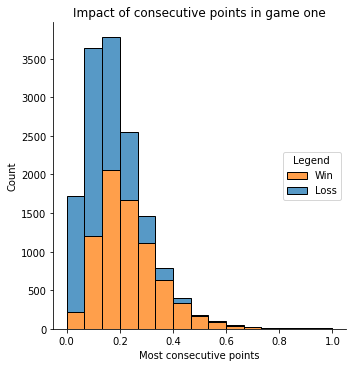

In [43]:
sns.displot(df, x="g1_mst_con_pts", hue="win", multiple='stack', bins=15, legend=False)
plt.xlabel('Most consecutive points')
plt.ylabel('Count')
plt.title('Impact of consecutive points in game one')
plt.legend(title='Legend', loc='center right', labels=['Win', 'Loss'])
plt.savefig('figures/g1_mst_con_pts.png', bbox_inches='tight')

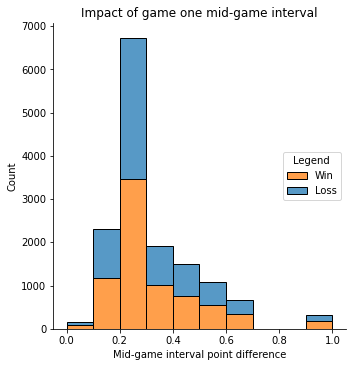

In [44]:
sns.displot(df, x="g1_int_pt_dif", hue="win", multiple='stack', bins=10, legend=False)
plt.xlabel('Mid-game interval point difference')
plt.ylabel('Count')
plt.title('Impact of game one mid-game interval')
plt.legend(title='Legend', loc='center right', labels=['Win', 'Loss'])
plt.savefig('figures/g1_int_pt_dif.png', bbox_inches='tight')

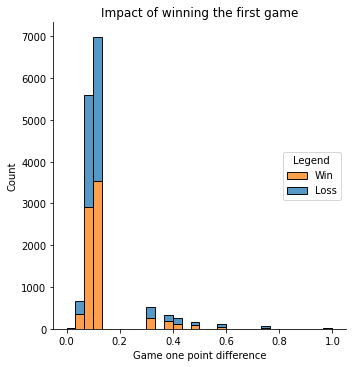

In [45]:
sns.displot(df, x="g1_pt_dif", hue="win", multiple='stack', bins=30, legend=False)
plt.xlabel('Game one point difference')
plt.ylabel('Count')
plt.title('Impact of winning the first game')
plt.legend(title='Legend', loc='center right', labels=['Win', 'Loss'])
plt.savefig('figures/g1_pt_dif.png', bbox_inches='tight')

In [46]:
corr=df.corr() # gives us the correlation values

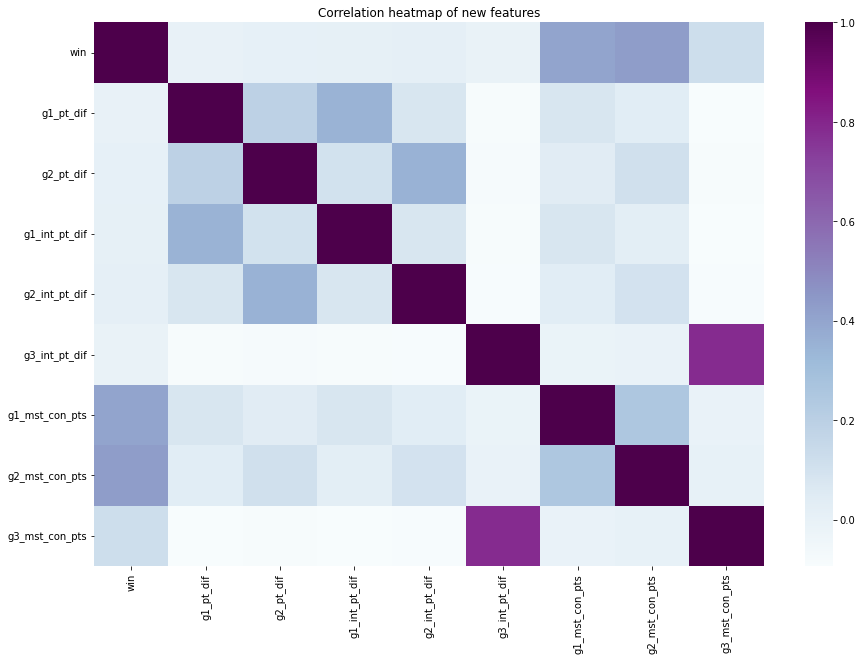

In [47]:
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot = False, cmap="BuPu")  # let's visualise the correlation matrix
plt.title('Correlation heatmap of new features')
plt.savefig('figures/correlation_heatmap.png', bbox_inches='tight')

In [48]:
df.isnull().sum() # Return the sum of occurrences of Null in each column

win               0
g1_pt_dif         0
g2_pt_dif         0
g1_int_pt_dif     0
g2_int_pt_dif     1
g3_int_pt_dif     0
g1_mst_con_pts    0
g2_mst_con_pts    0
g3_mst_con_pts    0
dtype: int64

In [49]:
# One record has escaped all previous efforts to remove Null
np.where(np.isnan(df))

(array([13987]), array([4]))

In [50]:
# Remove above 
df.loc[(df['g2_int_pt_dif'].isnull())]
df.drop(13987,inplace=True)

In [51]:
# Reset the index and index from 0 to number of rows
df = df.reset_index(drop = True) 

In [52]:
# Create x and y for test and train sets for analysis, y being 'target feature'
x = df.drop(['win'],axis=1)
y = df['win']

In [53]:
# Import sci-kit learn library which randomly splits data into test and train sets
from sklearn.model_selection import train_test_split

# Divide the dataset into train and test sets for both x and y, test_size 0.2 = 20% of the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [54]:
# Import sci-kit learn library to cross-validate the test data
from sklearn.model_selection import cross_val_score

In [55]:
# Create validation functions which will be reused with different models
def classify(model, x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)
    model.fit(x_train, y_train)
    print('Accuracy: ', model.score(x_test, y_test)*100)
    score = cross_val_score(model, x, y, cv=5)                  # we set the number of folds to 5
    print('Cross-validation accuracy: ', np.mean(score)*100)

In [56]:
# Import sci-kit learn library for logistic regression and initialise an instance
from sklearn.linear_model import LogisticRegression
lg_model = LogisticRegression()
classify(lg_model, x, y)  # pass logistic regression as the model, along with x and y, to the 'classify' function

Accuracy:  76.23089983022071
Cross-validation accuracy:  76.69461412120764


In [57]:
# Import sci-kit learn library for K-nearest neighbour and initialise an instance
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
classify(knn_model, x, y)

Accuracy:  79.25297113752123
Cross-validation accuracy:  78.807222078689


In [58]:
y_pred = knn_model.predict(x_test) # save predictions in y_pred

In [59]:
# Import sci-kit learn library to produce confusion matrix from svc model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

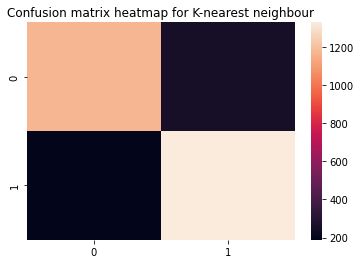

In [60]:
sns.heatmap(cm, annot=False) # plots the confusion matrix
plt.title('Confusion matrix heatmap for K-nearest neighbour')
plt.savefig('figures/confusion_matrix_heatmap_knn', bbox_inches='tight')

In [61]:
# Import sci-kit learn f1_score library to receive the F1 score for the model
from sklearn.metrics import f1_score

In [62]:
f1 = f1_score(y_test, y_pred)

In [63]:
f1

0.8559458588462778

In [64]:
df.to_csv('data_cleaned/df.csv', index=False)

In [65]:
# Create probability estimates of the positive class using both logistic regression model and knn model
lg_probas = lg_model.fit(x, y)
lg_probas = lg_probas.predict_log_proba(x)
knn_probas = knn_model.fit(x, y)
knn_probas = knn_model.predict_proba(x)

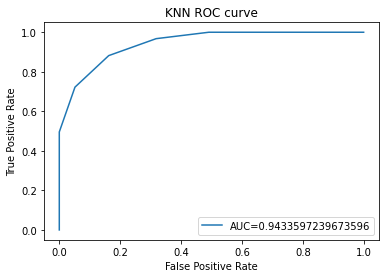

In [66]:
# Import sci-kit learn roc_curve libraries to calculate and plot ROC curve for models
from sklearn.metrics import roc_curve, roc_auc_score
# Calculate false positive rates and true positive rates based on true binary labels (y) and probability estimates (probas) for the positive class
# _proba returns array with two columns, only positive class is required so second column selected with [:, 1]
fpr, tpr, _ = roc_curve(y, knn_probas[:,1])
auc = roc_auc_score(y, knn_probas[:,1])

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('KNN ROC curve')
plt.legend(loc=4)
plt.savefig('figures/knn_roc', bbox_inches='tight')